# 1. 기본 설정 및 데이터 로드 

In [197]:
import warnings
warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.preprocessing import  LabelEncoder, OneHotEncoder

import random

In [198]:
train = pd.read_csv('./data/train.csv')
train = train.drop(['index'], axis=1)
train.fillna('NAN', inplace=True) 


test = pd.read_csv('./data/test.csv')
test = test.drop(['index'], axis=1)
test.fillna('NAN', inplace=True)

submit = pd.read_csv('./data/sample_submission.csv')

In [199]:
print(train.shape, test.shape)
train.head()

(26457, 19) (10000, 18)


,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NAN,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


#### 상관분석 후 변수 제거

In [169]:
train.describe()

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
count,26457.000000,2.645700e+04,26457.000000,26457.000000,26457.0,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000
mean,0.428658,1.873065e+05,-15958.053899,59068.750728,1.0,0.224742,0.294251,0.091280,2.196848,-26.123294,1.519560
std,0.747326,1.018784e+05,4201.589022,137475.427503,0.0,0.417420,0.455714,0.288013,0.916717,16.559550,0.702283
min,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000,0.000000
25%,0.000000,1.215000e+05,-19431.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000,1.000000
50%,0.000000,1.575000e+05,-15547.000000,-1539.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000,2.000000
75%,1.000000,2.250000e+05,-12446.000000,-407.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000,2.000000
max,19.000000,1.575000e+06,-7705.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000,2.000000


## 1. 로그 전환

## 1. Feature Engineering

### 1. 파생변수 추가

In [200]:
merge_data = pd.concat([train, test], axis = 0)
print(merge_data.shape)

(36457, 19)


In [184]:
merge_data['child_num'] + 1e-10

# DAYS_BIRTH, DAYS_EMPLOYED, before_DAYS 월별 단위로 변경
merge_data['DAYS_BIRTH'] = np.floor((-merge_data['DAYS_BIRTH'])/30)
merge_data['DAYS_EMPLOYED'] = np.floor((-merge_data['DAYS_EMPLOYED'])/30)
merge_data['before_DAYS'] = merge_data['DAYS_BIRTH'] - merge_data['DAYS_EMPLOYED']

# DAYS_BIRTH 파생변수
merge_data['DAYS_BIRTH_1'] = merge_data['child_num']  / merge_data['DAYS_BIRTH']
merge_data['DAYS_BIRTH_2'] = merge_data['income_total'] / merge_data['DAYS_BIRTH']
merge_data['DAYS_BIRTH_3'] = merge_data['begin_month'] / merge_data['DAYS_BIRTH']
merge_data['DAYS_BIRTH_4'] = merge_data['DAYS_EMPLOYED'] / merge_data['DAYS_BIRTH']
merge_data['DAYS_BIRTH_5'] = merge_data['before_DAYS'] / merge_data['DAYS_BIRTH']
merge_data['DAYS_BIRTH_6'] = merge_data['family_size'] / merge_data['DAYS_BIRTH']

# DAYS_EMPLOYED 파생변수
merge_data['DAYS_EMPLOYED_1'] = merge_data['child_num']  / merge_data['DAYS_EMPLOYED']
merge_data['DAYS_EMPLOYED_2'] = merge_data['income_total'] / merge_data['DAYS_EMPLOYED']
merge_data['DAYS_EMPLOYED_3'] = merge_data['begin_month'] / merge_data['DAYS_EMPLOYED']
merge_data['DAYS_EMPLOYED_4'] = merge_data['DAYS_BIRTH'] / merge_data['DAYS_EMPLOYED']
merge_data['DAYS_EMPLOYED_5'] = merge_data['before_DAYS'] / merge_data['DAYS_EMPLOYED']
merge_data['DAYS_EMPLOYED_6'] = merge_data['family_size'] / merge_data['DAYS_EMPLOYED']

# before_DAYS 파생변수
merge_data['before_DAYS_1'] = merge_data['child_num']  / merge_data['before_DAYS']
merge_data['before_DAYS_2'] = merge_data['income_total'] / merge_data['before_DAYS']
merge_data['before_DAYS_3'] = merge_data['begin_month'] / merge_data['before_DAYS']
merge_data['before_DAYS_4'] = merge_data['DAYS_BIRTH'] / merge_data['before_DAYS']
merge_data['before_DAYS_5'] = merge_data['DAYS_EMPLOYED'] / merge_data['before_DAYS']
merge_data['before_DAYS_6'] = merge_data['family_size'] / merge_data['before_DAYS']

# begin_month 파생변수
merge_data['begin_month_1'] = merge_data['child_num']  / merge_data['begin_month']
merge_data['begin_month_2'] = merge_data['income_total'] / merge_data['begin_month']
merge_data['begin_month_3'] = merge_data['DAYS_BIRTH'] / merge_data['begin_month']
merge_data['begin_month_4'] = merge_data['DAYS_EMPLOYED'] / merge_data['begin_month']
merge_data['begin_month_5'] = merge_data['before_DAYS'] / merge_data['begin_month']
merge_data['begin_month_6'] = merge_data['family_size'] / merge_data['begin_month']

# child_num 파생변수
merge_data['child_num_1'] = merge_data['begin_month']  / merge_data['child_num']
merge_data['child_num_2'] = merge_data['income_total'] / merge_data['child_num']
merge_data['child_num_3'] = merge_data['DAYS_BIRTH'] / merge_data['child_num']
merge_data['child_num_4'] = merge_data['DAYS_EMPLOYED'] / merge_data['child_num']
merge_data['child_num_5'] = merge_data['before_DAYS'] / merge_data['child_num']
merge_data['child_num_6'] = merge_data['family_size'] / merge_data['child_num']

# income_total 파생변수
merge_data['income_total_1'] = merge_data['begin_month']  / merge_data['income_total']
merge_data['income_total_2'] = merge_data['child_num'] / merge_data['income_total']
merge_data['income_total_3'] = merge_data['DAYS_BIRTH'] / merge_data['income_total']
merge_data['income_total_4'] = merge_data['DAYS_EMPLOYED'] / merge_data['income_total']
merge_data['income_total_5'] = merge_data['before_DAYS'] / merge_data['income_total']
merge_data['income_total_6'] = merge_data['family_size'] / merge_data['income_total']

# family_size 파생변수
merge_data['family_size_1'] = merge_data['begin_month']  / merge_data['family_size']
merge_data['family_size_2'] = merge_data['child_num'] / merge_data['family_size']
merge_data['family_size_3'] = merge_data['DAYS_BIRTH'] / merge_data['family_size']
merge_data['family_size_4'] = merge_data['DAYS_EMPLOYED'] / merge_data['family_size']
merge_data['family_size_5'] = merge_data['before_DAYS'] / merge_data['family_size']
merge_data['family_size_6'] = merge_data['income_total'] / merge_data['family_size']

# merge_data.fillna(0, inplace=True)
print(merge_data.shape)

merge_data = merge_data.fillna(-999)
train = merge_data[merge_data['credit'] != -999]
test = merge_data[merge_data['credit'] == -999]
test.drop('credit', axis = 1, inplace = True)


print(train.shape , test.shape)

# 365일 A/B 테스트 해볼것
# merge_data[''] = np.floor((-merge_data['DAYS_BIRTH'])/365)


(36457, 62)
(26457, 62) (10000, 61)


In [185]:
merge_data = merge_data.fillna(-999)
train = merge_data[merge_data['credit'] != -999]
test = merge_data[merge_data['credit'] == -999]
test.drop('credit', axis = 1, inplace = True)


print(train.shape , test.shape)

(26457, 62) (10000, 61)


In [201]:
#위에 난사보다 이게 더 성능이 좋음.

# DAYS_BIRTH
merge_data['DAYS_BIRTH_month']=np.floor((-merge_data['DAYS_BIRTH'])/30)-((np.floor((-merge_data['DAYS_BIRTH'])/30)/12).astype(int)*12)
merge_data['DAYS_BIRTH_week']=np.floor((-merge_data['DAYS_BIRTH'])/7)-((np.floor((-merge_data['DAYS_BIRTH'])/7)/4).astype(int)*4)

# DAYS_EMPLOYED
merge_data['DAYS_EMPLOYED_month']=np.floor((-merge_data['DAYS_EMPLOYED'])/30)-((np.floor((-merge_data['DAYS_EMPLOYED'])/30)/12).astype(int)*12)
merge_data['DAYS_EMPLOYED_week']=np.floor((-merge_data['DAYS_EMPLOYED'])/7)-((np.floor((-merge_data['DAYS_EMPLOYED'])/7)/4).astype(int)*4)

# before_EMPLOYED
merge_data['before_EMPLOYED']=merge_data['DAYS_BIRTH']-merge_data['DAYS_EMPLOYED']
merge_data['before_EMPLOYED_month']=np.floor((-merge_data['before_EMPLOYED'])/30)-((np.floor((-merge_data['before_EMPLOYED'])/30)/12).astype(int)*12)
merge_data['before_EMPLOYED_week']=np.floor((-merge_data['before_EMPLOYED'])/7)-((np.floor((-merge_data['before_EMPLOYED'])/7)/4).astype(int)*4)

# DAYS_BIRTH
merge_data['1new_1'] = merge_data['DAYS_BIRTH_month'] / merge_data['income_total']
merge_data['2new_1'] = merge_data['DAYS_BIRTH_week'] / merge_data['income_total']

# DAYS_EMPLOYED
merge_data['10new_1'] = merge_data['DAYS_EMPLOYED_month'] / merge_data['income_total']
merge_data['11new_1'] = merge_data['DAYS_EMPLOYED_week'] / merge_data['income_total']

# before_EMPLOYED
merge_data['12new_1'] = merge_data['before_EMPLOYED'] / merge_data['income_total']
merge_data['13new_1'] = merge_data['before_EMPLOYED_month'] / merge_data['income_total']
merge_data['14new_1'] = merge_data['before_EMPLOYED_week'] / merge_data['income_total']

# 융합 삭제
#merge_data['3new_1'] = merge_data['DAYS_EMPLOYED_month'] / merge_data['DAYS_BIRTH_month']
#merge_data['4new_1'] = merge_data['DAYS_EMPLOYED_month'] / merge_data['DAYS_BIRTH_week']
#merge_data['5new_1'] = merge_data['DAYS_EMPLOYED_week'] / merge_data['DAYS_BIRTH_month']
#merge_data['6new_1'] = merge_data['DAYS_EMPLOYED_week'] / merge_data['DAYS_BIRTH_week']

#merge_data['7new_1'] =  merge_data['begin_month'] / merge_data['DAYS_BIRTH_month']
#merge_data['8new_1'] =  merge_data['begin_month'] / merge_data['DAYS_EMPLOYED_month']
#merge_data['9new_1'] =  merge_data['begin_month'] / merge_data['before_EMPLOYED_month']


# 소득대비 
merge_data['DAYS_BIRTH'] = merge_data['DAYS_BIRTH'] / -365
merge_data['DAYS_EMPLOYED'] = merge_data['DAYS_EMPLOYED'] / -365

merge_data['new_1'] = merge_data['child_num'] / merge_data['income_total']
merge_data['new_2'] = merge_data['family_size'] / merge_data['income_total']
merge_data['new_3'] = merge_data['DAYS_BIRTH'] / merge_data['income_total']
merge_data['new_4'] = merge_data['DAYS_EMPLOYED'] / merge_data['income_total']
merge_data['new_5'] = merge_data['begin_month'] / merge_data['income_total']
merge_data['new_6'] =  merge_data['DAYS_EMPLOYED'] / merge_data['DAYS_BIRTH']


merge_data = merge_data.fillna(-999)
train = merge_data[merge_data['credit'] != -999]
test = merge_data[merge_data['credit'] == -999]
test.drop('credit', axis = 1, inplace = True)


print(train.shape , test.shape)

(26457, 39) (10000, 38)


#### 원핫인코딩

## Training



#### 원본

In [213]:
train = train.drop(['index'], axis=1)
test = test.drop(['index'], axis=1)

In [215]:
object_col = []
for col in train.columns:
    if train[col].dtype == 'object':
        object_col.append(col)
print(object_col)        
enc = OneHotEncoder()
enc.fit(train.loc[:,object_col])


train_onehot_df = pd.DataFrame(enc.transform(train.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
train.drop(object_col, axis=1, inplace=True)
train = pd.concat([train, train_onehot_df], axis=1)    

test_onehot_df = pd.DataFrame(enc.transform(test.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
test.drop(object_col, axis=1, inplace=True)
test = pd.concat([test, test_onehot_df], axis=1)

['occyp_type']


In [216]:
# train는 feature와 target 값 같이 있음
# test는 feature 값만 있다
print(train.shape, test.shape)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
folds=[]
for train_idx, valid_idx in skf.split(train, train['credit']):
    folds.append((train_idx, valid_idx))

random.seed(42)
lgb_models={}
for fold in range(10):
    print(f'===================================={fold+1}============================================')
    # 데이터 분할
    train_idx, valid_idx = folds[fold] # 인덱스
    X_train, X_valid, y_train, y_valid = train.drop(['credit'],axis=1).iloc[train_idx].values,\
                                         train.drop(['credit'],axis=1).iloc[valid_idx].values,\
                                         train['credit'][train_idx].values, train['credit'][valid_idx].values 
    
    
    # 모델
    lgb = LGBMClassifier(n_estimators=1000)
    
    lgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], 
            early_stopping_rounds=50, verbose=100)
    
    
    lgb_models[fold]=lgb
    print(f'================================================================================\n\n')

(26457, 76) (10000, 75)
====================================1============================================
Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 0.607688	valid_1's multi_logloss: 0.728482
[200]	training's multi_logloss: 0.506961	valid_1's multi_logloss: 0.709182
[300]	training's multi_logloss: 0.435856	valid_1's multi_logloss: 0.701796
Early stopping, best iteration is:
[277]	training's multi_logloss: 0.450163	valid_1's multi_logloss: 0.700885


====================================2============================================
Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 0.607634	valid_1's multi_logloss: 0.729539
[200]	training's multi_logloss: 0.503984	valid_1's multi_logloss: 0.707435
[300]	training's multi_logloss: 0.43262	valid_1's multi_logloss: 0.705159
Early stopping, best iteration is:
[283]	training's multi_logloss: 0.443356	valid_1's multi_logloss: 0.704803


=================

#### 파라미터 조정

In [217]:
submit.iloc[:,1:]=0
for fold in range(10):
    submit.iloc[:,1:] += lgb_models[fold].predict_proba(test)/10

In [218]:
submit.to_csv('5submission.csv', index=False)

In [219]:
submit.head(20)

,index,0,1,2
0,26457,0.295349,0.185710,0.518941
1,26458,0.038655,0.108261,0.853084
2,26459,0.076906,0.150575,0.772519
3,26460,0.116961,0.144367,0.738672
4,26461,0.053732,0.139373,0.806895
5,26462,0.058443,0.334570,0.606987
6,26463,0.057824,0.107248,0.834929
7,26464,0.483463,0.181733,0.334805
8,26465,0.017648,0.074477,0.907875
9,26466,0.134771,0.146299,0.718930


###  ========================================================================

In [220]:
from sklearn.model_selection import train_test_split
ftr_train = train.drop('credit', axis = 1, inplace = False)
target = train['credit']

train_x, valid_x, train_y, valid_y = train_test_split(ftr_train, target, test_size = 0.2, random_state = 10)
print(train_x.shape, valid_x.shape)

from sklearn.model_selection import cross_val_score

lgb_clf = LGBMClassifier(n_estimators=100, random_state = 22)

scores = cross_val_score(lgb_clf, ftr_train , target , cv=10)

for iter_count,accuracy in enumerate(scores):
    print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count+1, accuracy))

print("평균 정확도: {0:.4f}".format(np.mean(scores))) # 0.711

(21165, 75) (5292, 75)
교차 검증 1 정확도: 0.7101
교차 검증 2 정확도: 0.7007
교차 검증 3 정확도: 0.7075
교차 검증 4 정확도: 0.7063
교차 검증 5 정확도: 0.7094
교차 검증 6 정확도: 0.7063
교차 검증 7 정확도: 0.7086
교차 검증 8 정확도: 0.7127
교차 검증 9 정확도: 0.7017
교차 검증 10 정확도: 0.7078
평균 정확도: 0.7071


In [268]:
# 정규화 및 이상치 제거 
import numpy as np

#candidate = ['income_total', 'DAYS_EMPLOYED', 'family_size']
candidate = ['income_total', 'family_size']
for cand in candidate :
    train[cand] = ((train[cand] - min(train[cand]) / min(train[cand]) - min(train[cand])))
    test[cand] = ((test[cand] - min(test[cand]) / min(test[cand]) - min(test[cand])))
    
    
def remove_outlier(train,column):
    df = train[column]
    # 1분위수
    quan_25 = np.percentile(df.values, 25)
    
    # 3분위수
    quan_75 = np.percentile(df.values, 75)
    
    iqr = quan_75 - quan_25
    
    lowest = quan_25 - iqr * 1.5
    highest = quan_75 + iqr * 1.5
    outlier_index = df[(df < lowest) | (df > highest)].index
    print('outlier의 수 : ' , len(outlier_index))
    train.drop(outlier_index, axis = 0, inplace = True)
    
    return train


#for cand in candidate:  
#    train = remove_outlier(train,cand)
#    test = remove_outlier(test,cand)
#len(train)
#len(test)

In [134]:
target_train_type[["occyp_type",'credit']]

,occyp_type,credit
0,NAN,1.0
1,NAN,2.0
2,NAN,2.0
3,NAN,2.0
4,NAN,2.0
...,...,...
8166,NAN,2.0
8167,NAN,2.0
8168,NAN,1.0
8169,NAN,1.0


<AxesSubplot:>

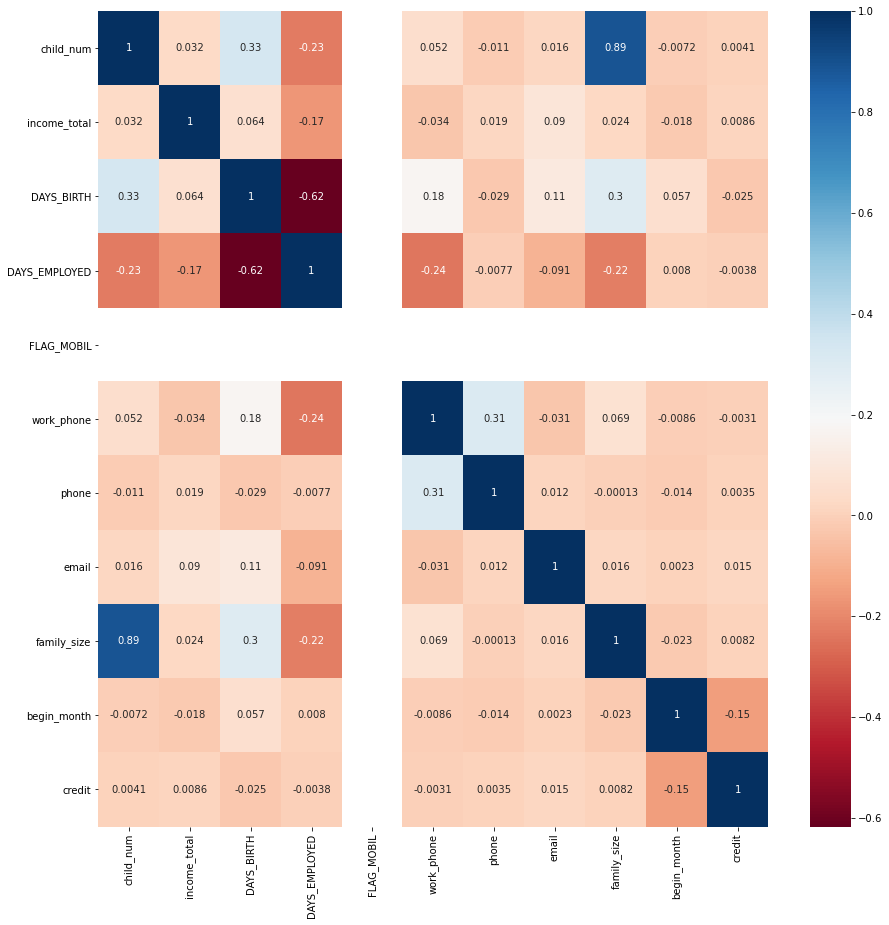

In [203]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = train[train.columns.tolist()].corr()
corr
plt.figure(figsize =(15,15))
sns.heatmap(corr,cmap='RdBu', annot = True) # child_num 삭제

# train.drop('child_num', axis = 1, inplace = True)
# test.drop('child_num', axis = 1, inplace = True)

In [29]:
## Train data
train_type = train[train['occyp_type'] != 'NAN'] # 학습용
target_train_type = train[train['occyp_type'] == 'NAN'] # 테스트용
print(train_type.shape, target_train_type.shape) ##########################################

## test 데이터
#target_train_type = test[test['occyp_type'] == 'NAN']
#train_type = test[test['occyp_type'] != 'NAN']
#print(target_train_type.shape, train_type.shape)

## 2. occyp_type은 레이블인코딩 전환, test에서 삭제 
class_le = LabelEncoder()
train_type['occyp_type'] = class_le.fit_transform(train_type['occyp_type'].values)
print(class_le.inverse_transform(train_type['occyp_type']))
#train_type['occyp_type'] = pd.factorize(train_type['occyp_type'])[0]

target_train_type.drop('occyp_type', axis = 1)

## 3. 범주형 전환
object_col = []
for col in train_type.columns:
    if train[col].dtype == 'object':
        object_col.append(col)
        
object_col = object_col[0:-1] 

enc = OneHotEncoder()
enc.fit(train_type.loc[:,object_col])

# train
train_onehot_df = pd.DataFrame(enc.transform(train_type.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
train_type.drop(object_col, axis=1, inplace=True)
train_type = train_type.reset_index()
train_onehot_df = train_onehot_df.reset_index()
train_type = pd.concat([train_type, train_onehot_df], axis=1)    

# test
test_onehot_df = pd.DataFrame(enc.transform(target_train_type.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
target_train_type.drop(object_col, axis=1, inplace=True)

target_train_type = target_train_type.reset_index()
test_onehot_df = test_onehot_df.reset_index()
target_train_type = pd.concat([target_train_type, test_onehot_df], axis=1)
print(train_type.shape, target_train_type.shape) ##########################################

# 2. train, test에서 index credit 제거  credit
training = train_type.drop(['index','credit'] , axis = 1, inplace = False) # train에서는 credit
testing = target_train_type.drop(['index', 'occyp_type','credit'], axis = 1, inplace = False)
print(training.shape, testing.shape) ##########################################

# 학습 테스트 분류
Train = training.drop('occyp_type', axis = 1, inplace = False)
target = training['occyp_type']


X_train, X_test, y_train, y_test = train_test_split(Train, target, 
                                                    stratify=target, test_size=0.25,
                                                    random_state = 1000)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(3152, 18) (6848, 18)
['Core staff' 'Laborers' 'Drivers' ... 'Laborers' 'Medicine staff'
 'Laborers']
(6848, 40) (3152, 40)
(6848, 38) (3152, 37)
(5136, 37) (1712, 37) (5136,) (1712,)


### 5.직업 유형 예측

In [166]:
train = pd.read_csv('./data/train.csv')
train = train.drop(['index'], axis=1)
train.fillna('NAN', inplace=True) 


test = pd.read_csv('./data/test.csv')
test = test.drop(['index'], axis=1)
test.fillna('NAN', inplace=True)

submit = pd.read_csv('./data/sample_submission.csv')

In [202]:
## 원핫인코딩 전환
def one_hot_encoding(df_data):
    
    # 범주형 변수 담기
    object_col = []
    for col in df_data.columns:
        if df_data[col].dtype == 'object':
            object_col.append(col)
            
    # occyp_type을 제외한 원핫인코딩
    object_col.remove('occyp_type')
    
    # 원핫인코딩
    enc = OneHotEncoder()
    enc.fit(df_data.loc[:,object_col])
    
    # 데이터 변환
    onhot_df = pd.DataFrame(enc.transform(df_data.loc[:,object_col]).toarray(),\
                                   columns=enc.get_feature_names(object_col))
    df_data.drop(object_col, axis=1, inplace=True)
    df_data = df_data.reset_index()
    onhot_df = onhot_df.reset_index()
    df_data = pd.concat([df_data, onhot_df], axis=1)    

    print("## 원핫 인코딩 진행 완료 ##")
    print(df_data.shape)
    
    return df_data

In [203]:
## 예측 정확도 파악
def predict_type(df_train_data, df_target_data):
    Train = df_train_data.drop('occyp_type', axis = 1, inplace = False)
    target = df_train_data['occyp_type']

    X_train, X_test, y_train, y_test = train_test_split(Train, target, 
                                                    stratify=target, test_size=0.20,
                                                    random_state = 1000)

    print("## train / test 분할 완료 ##")
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    
    print("## 예측을 진행합니다 ##")
    rf_clf = RandomForestClassifier(n_estimators = 1000, random_state=20)
    rf_clf.fit(X_train , y_train)
    pred = rf_clf.predict(X_test)
    accuracy = accuracy_score(y_test , pred)
    print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy)) 
    
    # 적용
    print('모델 적용중.............')
    pred1 = rf_clf.predict(df_target_data)
    
    class_le = LabelEncoder()
    df_train_data['occyp_type'] = class_le.fit_transform(df_train_data['occyp_type'].values)
    
    df_target_data['occyp_type'] = class_le.inverse_transform(pred1).tolist()
    df_target_data['occyp_type'].value_counts()
    print(df_train_data.shape, df_target_data.shape)
    
    final_data = pd.concat([df_train_data.reset_index().drop(['level_0','index'], axis = 1),\
                            df_target_data.reset_index().drop(['level_0','index'], axis = 1)], axis = 0)
    print(final_data['occyp_type'].value_counts())
    print('완료')
    return final_data.reset_index()

#### 원핫적용

In [204]:
train = one_hot_encoding(train)
test = one_hot_encoding(test)

## 원핫 인코딩 진행 완료 ##
(26457, 61)
## 원핫 인코딩 진행 완료 ##
(10000, 60)


In [205]:
train_type = train[train['occyp_type'] != 'NAN']
target_train_type = train[train['occyp_type'] == 'NAN']
    
test_type = test[test['occyp_type'] != 'NAN']
target_test_type = test[test['occyp_type'] == 'NAN']
    
print("## type 여부 분할 완료 ##")
print(train_type.shape, target_train_type.shape, test_type.shape, target_test_type.shape)    

## type 여부 분할 완료 ##
(18286, 61) (8171, 61) (6848, 60) (3152, 60)


#### 타겟 레이블 인코딩

In [206]:
class_le = LabelEncoder()
train_type['occyp_type'] = class_le.fit_transform(train_type['occyp_type'].values)
test_type['occyp_type'] = class_le.fit_transform(test_type['occyp_type'].values)

print("## type 여부 분할 완료 ##")
print(train_type.shape, target_train_type.shape, test_type.shape, target_test_type.shape)    

## type 여부 분할 완료 ##
(18286, 61) (8171, 61) (6848, 60) (3152, 60)


In [207]:
train_training = train_type #★.drop(['credit'] , axis = 1, inplace = False)
train_target = target_train_type.drop(['occyp_type'], axis = 1, inplace = False) # ★,'credit'
          
test_training = test_type
test_target = target_test_type.drop(['occyp_type'], axis = 1, inplace = False)
print("## 데이터 분할 완료 ##")
print(train_training.shape, train_target.shape, test_training.shape, test_target.shape)    

## 데이터 분할 완료 ##
(18286, 61) (8171, 60) (6848, 60) (3152, 59)


### 적용


In [208]:
train = predict_type(train_training, train_target) # 0.8573 -> 원핫적용시 : 
test = predict_type(test_training, test_target) # 0.6818 -> 원핫적용시 : 

## train / test 분할 완료 ##
(14628, 60) (3658, 60) (14628,) (3658,)
## 예측을 진행합니다 ##
랜덤 포레스트 정확도: 0.8997
모델 적용중.............
(18286, 61) (8171, 61)
8     7044
14    4476
3     3316
10    2883
1     1901
4     1801
6     1095
0     1021
11    1007
16     692
2      460
12     246
9      127
17     124
15      98
13      63
5       62
7       41
Name: occyp_type, dtype: int64
완료
## train / test 분할 완료 ##
(5478, 59) (1370, 59) (5478,) (1370,)
## 예측을 진행합니다 ##
랜덤 포레스트 정확도: 0.7577
모델 적용중.............
(6848, 60) (3152, 60)
8     2719
14    1679
3     1366
10    1088
11     671
4      619
0      401
6      392
16     323
1      229
2      199
12     104
15      54
17      50
9       48
5       23
7       19
13      16
Name: occyp_type, dtype: int64
완료


In [209]:
train['occyp_type'] = class_le.inverse_transform(train['occyp_type']).tolist()
test['occyp_type'] = class_le.inverse_transform(test['occyp_type']).tolist()